In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter16-RNR"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Twitter16-RNR_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(818, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter16_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt,cv_fold,tt,tvt2,tvt2_1,tvt2_2,tvt2_3
0,656955120626880512,correct predictions in back to the future ii U...,false,training,1,training,validation,training,training,validation
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...,true,training,3,training,training,validation,training,training
2,613404935003217920,cops bought the alleged church shooter burger ...,false,training,2,test,training,training,training,training
3,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,training,3,test,training,training,training,training
4,714598641827246081,an open letter to trump voters from his top st...,unverified,training,1,test,training,validation,training,training


In [4]:
labels_str = ['rumour', 'non-rumour']
labels_str

['rumour', 'non-rumour']

In [5]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] in ['true', 'false', 'unverified']:
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(545, 768)
(192, 768)
(81, 768)
(545,)
(192,)
(81,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(737, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(737,)


In [10]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [11]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 4-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 75.0
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 95.92529711375212, Validation Accuracy : 100.0, Train Loss : 0.4201195389032364, Validation Loss : 0.05288133770227432
-- Epoch 100, Train_Accuracy : 97.96264855687606, Validation Accuracy : 100.0, Train Loss : 0.14097833633422852, Validation Loss : 0.013841873966157436
-- Epoch 150, Train_Accuracy : 98.98132427843802, Validation Accuracy : 100.0, Train Loss : 0.06588390842080116, Validation Loss : 0.0047350660897791386
-- Epoch 200, Train_Accuracy : 99.32088285229202, Validation Accuracy : 99.32432432432432, Train Loss : 0.045816756784915924, Validation Loss : 0.013919967226684093
-- Epoch 250, Train_Accuracy : 99.66044142614601, Validation Accuracy : 100.0, Train Loss : 0.024527084548026323, Validation Loss : 0.010728833265602589
-- Epoch 300, Train_Accuracy : 99.66044142614601, Va

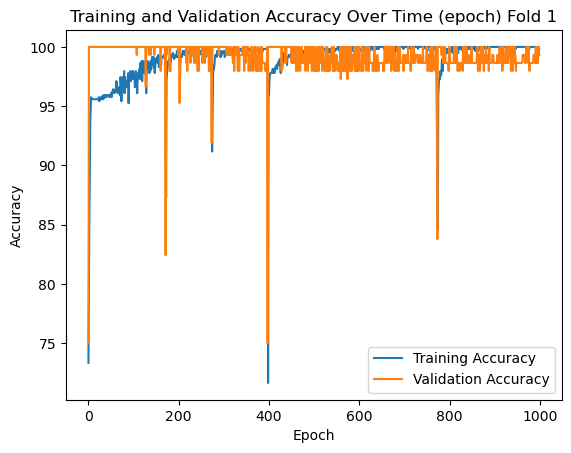

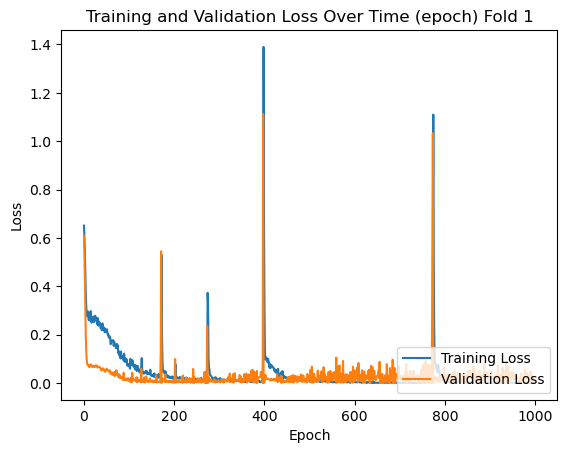

Exec Time : 14.99 seconds
loading model from ../../data/models/cross-validation/Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([589])
Binary Class Evaluation

True Positive : 129
False Positive : 9
False Negative : 19
True Negative : 432

Class non-rumour Evaluation
- Precision : 93.478 %
- Recall : 87.162 %
- F1 : 0.9021

Class rumour Evaluation
- Precision : 95.787 %
- Recall : 97.959 %
- F1 : 0.96861

Combined Evaluation
- Accuracy : 95.246 %
- Precision : 94.633 %
- Recall : 92.561 %
- F1 : 0.93586
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Train, 95.246, 94.633, 92.561, 0.93586, 93.478, 87.162, 0.9021, 95.787, 97.959, 0.96861, 
Confusion Matrix Scikit-learn: 
[[432   9]
 [ 19 129]]


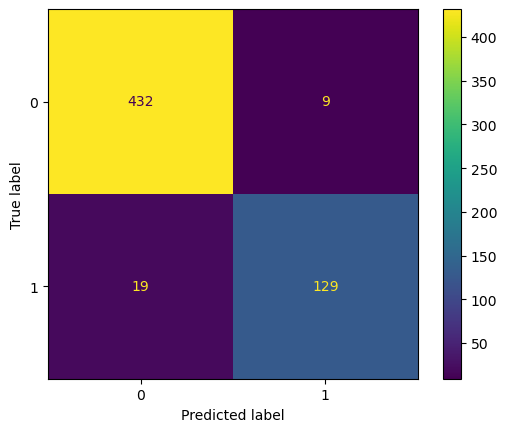


Validation Set
Predictions : torch.Size([148])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 0
True Negative : 111

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[111   0]
 [  0  37]]


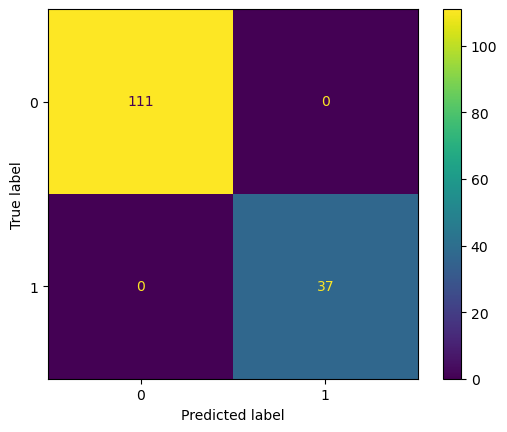


Test Set
Predictions : torch.Size([81])
Binary Class Evaluation

True Positive : 11
False Positive : 0
False Negative : 9
True Negative : 61

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 55.0 %
- F1 : 0.70968

Class rumour Evaluation
- Precision : 87.143 %
- Recall : 100.0 %
- F1 : 0.9313

Combined Evaluation
- Accuracy : 88.889 %
- Precision : 93.571 %
- Recall : 77.5 %
- F1 : 0.84781
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Test, 88.889, 93.571, 77.5, 0.84781, 100.0, 55.0, 0.70968, 87.143, 100.0, 0.9313, 
81
81
Confusion Matrix Scikit-learn: 
[[61  0]
 [ 9 11]]


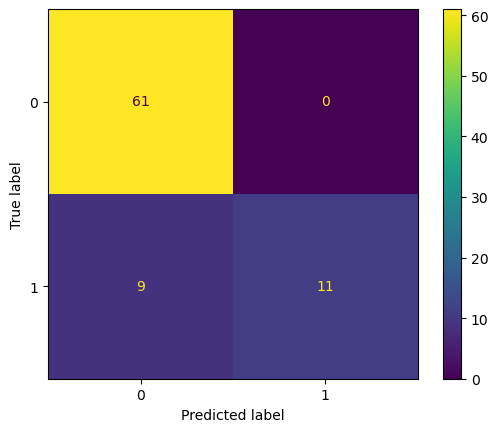

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 75.0
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.09507640067912, Validation Accuracy : 100.0, Train Loss : 0.4439648985862732, Validation Loss : 0.05716670677065849
-- Epoch 100, Train_Accuracy : 97.96264855687606, Validation Accuracy : 99.32432432432432, Train Loss : 0.1338409036397934, Validation Loss : 0.04977129027247429
-- Epoch 150, Train_Accuracy : 97.79286926994907, Validation Accuracy : 100.0, Train Loss : 0.08533087931573391, Validation Loss : 0.008777206763625145
-- Epoch 200, Train_Accuracy : 99.66044142614601, Validation Accuracy : 99.32432432432432, Train Loss : 0.029261428397148848, Validation Loss : 0.011402481235563755
-- Epoch 250, Train_Accuracy : 99.49066213921901, Validation Accuracy : 98.64864864864865, Train Loss : 0.02435310883447528, Validation Loss : 0.02388538047671318
-- Epoch 300, Train_Accuracy : 99.66044142614601, Validation Accuracy : 98.64864864864865, Train Loss : 0

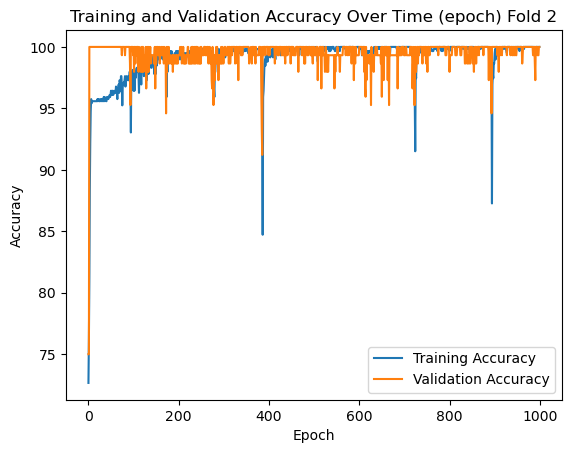

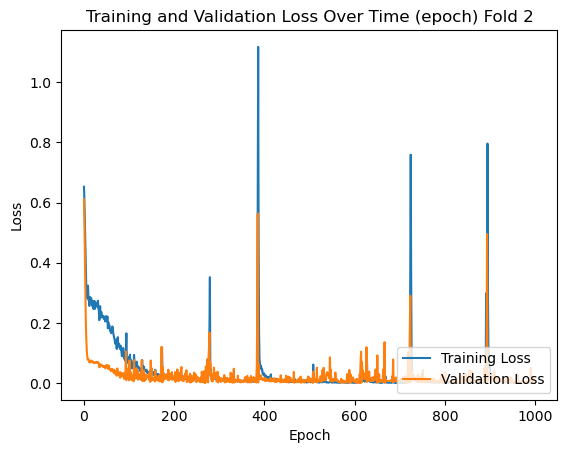

Exec Time : 12.42 seconds
loading model from ../../data/models/cross-validation/Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([589])
Binary Class Evaluation

True Positive : 131
False Positive : 10
False Negative : 17
True Negative : 431

Class non-rumour Evaluation
- Precision : 92.908 %
- Recall : 88.514 %
- F1 : 0.90657

Class rumour Evaluation
- Precision : 96.205 %
- Recall : 97.732 %
- F1 : 0.96963

Combined Evaluation
- Accuracy : 95.416 %
- Precision : 94.557 %
- Recall : 93.123 %
- F1 : 0.93835
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Train, 95.416, 94.557, 93.123, 0.93835, 92.908, 88.514, 0.90657, 96.205, 97.732, 0.96963, 
Confusion Matrix Scikit-learn: 
[[431  10]
 [ 17 131]]


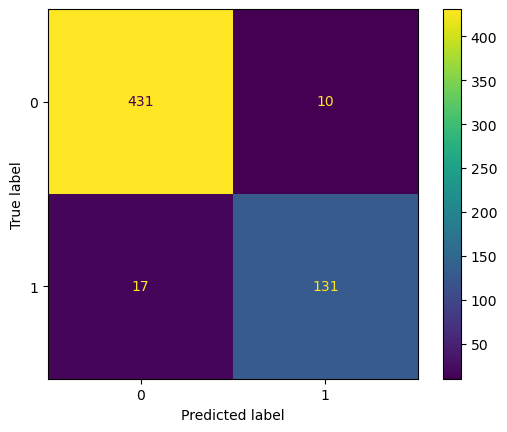


Validation Set
Predictions : torch.Size([148])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 0
True Negative : 111

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[111   0]
 [  0  37]]


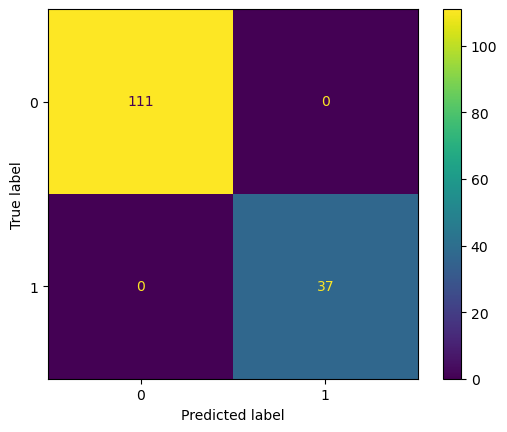


Test Set
Predictions : torch.Size([81])
Binary Class Evaluation

True Positive : 13
False Positive : 0
False Negative : 7
True Negative : 61

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 65.0 %
- F1 : 0.78788

Class rumour Evaluation
- Precision : 89.706 %
- Recall : 100.0 %
- F1 : 0.94574

Combined Evaluation
- Accuracy : 91.358 %
- Precision : 94.853 %
- Recall : 82.5 %
- F1 : 0.88246
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Test, 91.358, 94.853, 82.5, 0.88246, 100.0, 65.0, 0.78788, 89.706, 100.0, 0.94574, 
81
81
Confusion Matrix Scikit-learn: 
[[61  0]
 [ 7 13]]


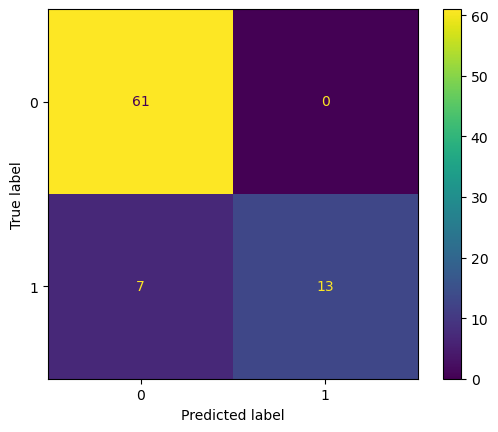

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.10169491525424, Validation Accuracy : 100.0, Train Loss : 0.4250004440546036, Validation Loss : 0.05806433781981468
-- Epoch 100, Train_Accuracy : 97.79661016949153, Validation Accuracy : 100.0, Train Loss : 0.16525709629058838, Validation Loss : 0.01248058583587408
-- Epoch 150, Train_Accuracy : 97.79661016949153, Validation Accuracy : 100.0, Train Loss : 0.08691181428730488, Validation Loss : 0.006469895131886005
-- Epoch 200, Train_Accuracy : 99.32203389830508, Validation Accuracy : 100.0, Train Loss : 0.03765371302142739, Validation Loss : 0.00846250168979168
-- Epoch 250, Train_Accuracy : 99.32203389830508, Validation Accuracy : 99.31972789115646, Train Loss : 0.03328061569482088, Validation Loss : 0.020121028646826744
-- Epoch 300, Train_Accuracy : 99.32203389830508, Validation Accuracy : 100.0, Train Loss : 0.043631404638290405, Validation Loss : 0.004276517778635025
-- Epoch 350, 

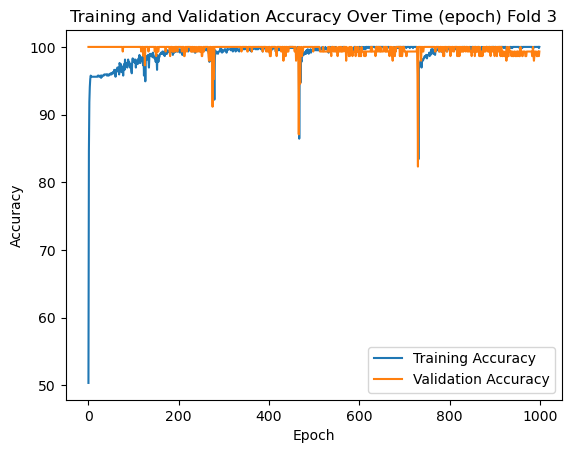

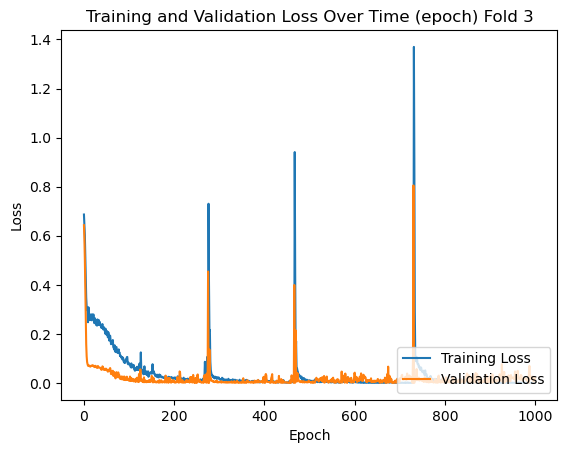

Exec Time : 12.35 seconds
loading model from ../../data/models/cross-validation/Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([590])
Binary Class Evaluation

True Positive : 130
False Positive : 10
False Negative : 18
True Negative : 432

Class non-rumour Evaluation
- Precision : 92.857 %
- Recall : 87.838 %
- F1 : 0.90278

Class rumour Evaluation
- Precision : 96.0 %
- Recall : 97.738 %
- F1 : 0.96861

Combined Evaluation
- Accuracy : 95.254 %
- Precision : 94.429 %
- Recall : 92.788 %
- F1 : 0.93601
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Train, 95.254, 94.429, 92.788, 0.93601, 92.857, 87.838, 0.90278, 96.0, 97.738, 0.96861, 
Confusion Matrix Scikit-learn: 
[[432  10]
 [ 18 130]]


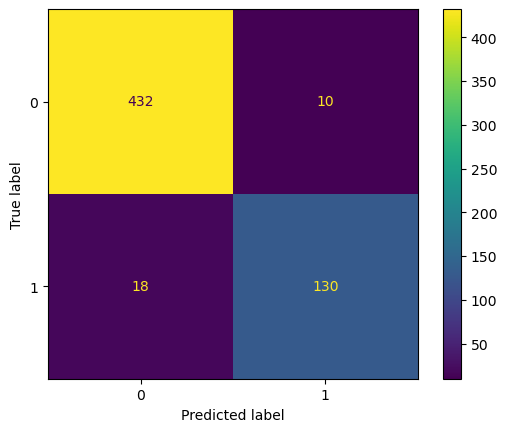


Validation Set
Predictions : torch.Size([147])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 0
True Negative : 110

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[110   0]
 [  0  37]]


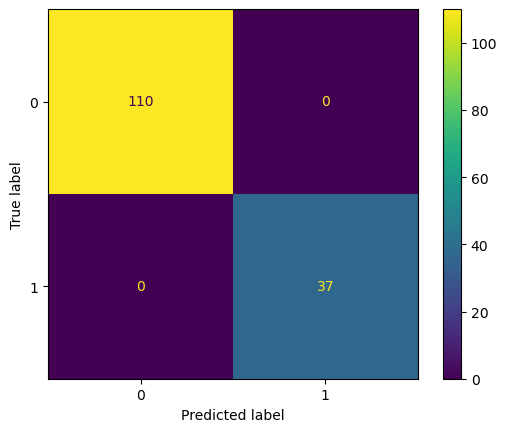


Test Set
Predictions : torch.Size([81])
Binary Class Evaluation

True Positive : 13
False Positive : 0
False Negative : 7
True Negative : 61

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 65.0 %
- F1 : 0.78788

Class rumour Evaluation
- Precision : 89.706 %
- Recall : 100.0 %
- F1 : 0.94574

Combined Evaluation
- Accuracy : 91.358 %
- Precision : 94.853 %
- Recall : 82.5 %
- F1 : 0.88246
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Test, 91.358, 94.853, 82.5, 0.88246, 100.0, 65.0, 0.78788, 89.706, 100.0, 0.94574, 
81
81
Confusion Matrix Scikit-learn: 
[[61  0]
 [ 7 13]]


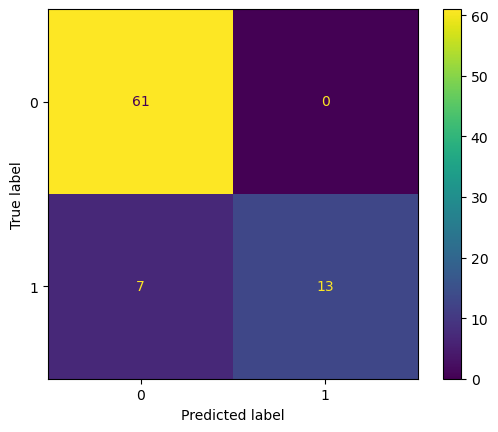

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 97.95918367346938
Saving after new best accuracy : 98.63945578231292
-- Epoch 50, Train_Accuracy : 96.27118644067797, Validation Accuracy : 97.95918367346938, Train Loss : 0.4108126163482666, Validation Loss : 0.0897243320941925
-- Epoch 100, Train_Accuracy : 98.30508474576271, Validation Accuracy : 97.95918367346938, Train Loss : 0.1382807344198227, Validation Loss : 0.08303298056125641
-- Epoch 150, Train_Accuracy : 98.98305084745763, Validation Accuracy : 93.87755102040816, Train Loss : 0.07178044877946377, Validation Loss : 0.1873530000448227
-- Epoch 200, Train_Accuracy : 99.49152542372882, Validation Accuracy : 97.27891156462584, Train Loss : 0.024549677735194564, Validation Loss : 0.15181522071361542
-- Epoch 250, Train_Accuracy : 99.32203389830508, Validation Accuracy : 97.27891156462584, Train Loss : 0.042498086579144, Validation Loss : 0.12155421078205109
-- Epoch 300, Train_Accuracy : 99.66101694915254, Validation A

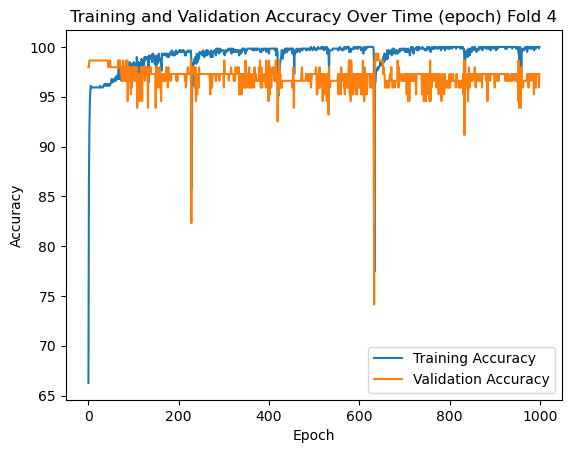

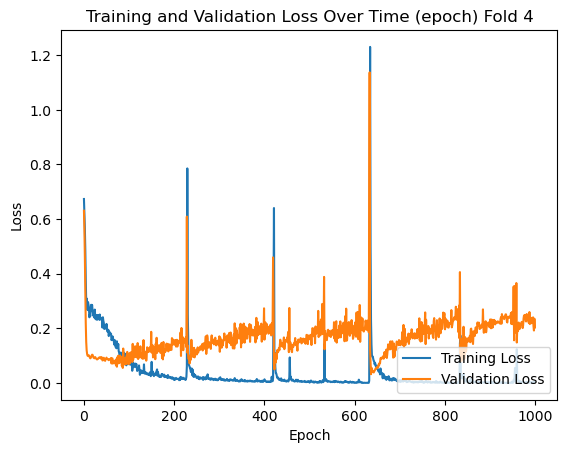

Exec Time : 12.47 seconds
loading model from ../../data/models/cross-validation/Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([590])
Binary Class Evaluation

True Positive : 136
False Positive : 0
False Negative : 12
True Negative : 442

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 91.892 %
- F1 : 0.95775

Class rumour Evaluation
- Precision : 97.357 %
- Recall : 100.0 %
- F1 : 0.98661

Combined Evaluation
- Accuracy : 97.966 %
- Precision : 98.678 %
- Recall : 95.946 %
- F1 : 0.97293
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Train, 97.966, 98.678, 95.946, 0.97293, 100.0, 91.892, 0.95775, 97.357, 100.0, 0.98661, 
Confusion Matrix Scikit-learn: 
[[442   0]
 [ 12 136]]


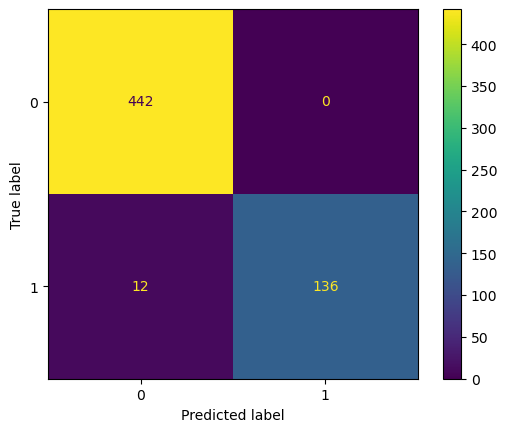


Validation Set
Predictions : torch.Size([147])
Binary Class Evaluation

True Positive : 36
False Positive : 0
False Negative : 1
True Negative : 110

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 97.297 %
- F1 : 0.9863

Class rumour Evaluation
- Precision : 99.099 %
- Recall : 100.0 %
- F1 : 0.99548

Combined Evaluation
- Accuracy : 99.32 %
- Precision : 99.55 %
- Recall : 98.649 %
- F1 : 0.99097
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Validation, 99.32, 99.55, 98.649, 0.99097, 100.0, 97.297, 0.9863, 99.099, 100.0, 0.99548, 
Confusion Matrix Scikit-learn: 
[[110   0]
 [  1  36]]


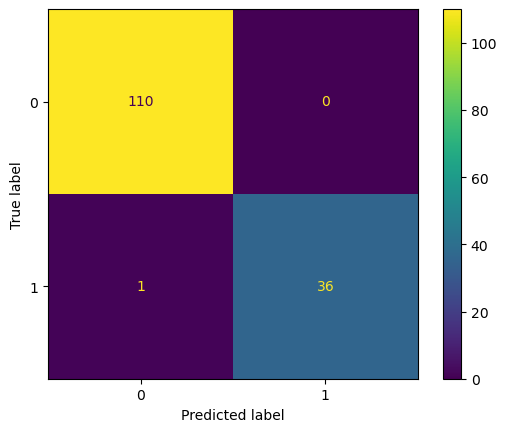


Test Set
Predictions : torch.Size([81])
Binary Class Evaluation

True Positive : 14
False Positive : 2
False Negative : 6
True Negative : 59

Class non-rumour Evaluation
- Precision : 87.5 %
- Recall : 70.0 %
- F1 : 0.77778

Class rumour Evaluation
- Precision : 90.769 %
- Recall : 96.721 %
- F1 : 0.93651

Combined Evaluation
- Accuracy : 90.123 %
- Precision : 89.135 %
- Recall : 83.361 %
- F1 : 0.86151
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Test, 90.123, 89.135, 83.361, 0.86151, 87.5, 70.0, 0.77778, 90.769, 96.721, 0.93651, 
81
81
Confusion Matrix Scikit-learn: 
[[59  2]
 [ 6 14]]


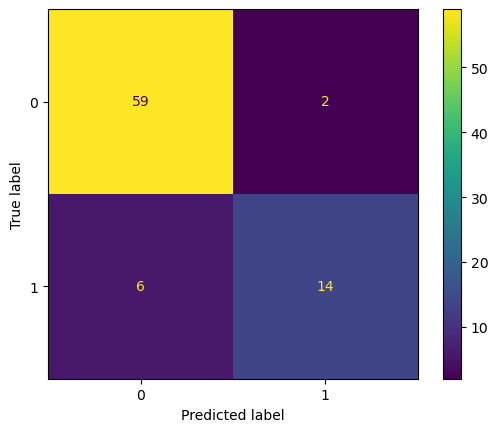

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 82.99319727891157
Saving after new best accuracy : 83.6734693877551
-- Epoch 50, Train_Accuracy : 99.83050847457628, Validation Accuracy : 79.59183673469387, Train Loss : 0.04254386993125081, Validation Loss : 0.9125931859016418
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 78.91156462585035, Train Loss : 0.006627010850934312, Validation Loss : 1.5139820575714111
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 76.87074829931973, Train Loss : 0.0012107331203878857, Validation Loss : 1.945512056350708
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 77.55102040816327, Train Loss : 0.000161178422786179, Validation Loss : 2.2598469257354736
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 76.87074829931973, Train Loss : 7.973575202413485e-05, Validation Loss : 2.475973606109619
-- Epoch 300, Train_Accuracy : 99.83050847457628, Validation Accuracy : 78.91156462585035, Train Loss : 0.0

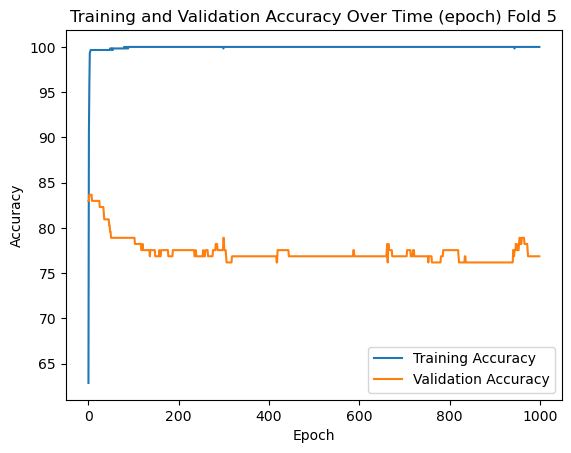

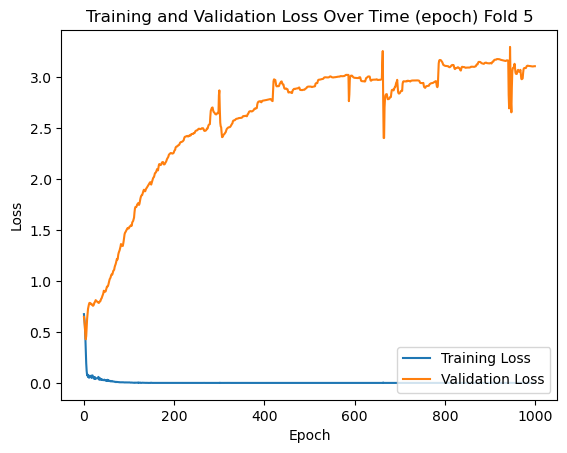

Exec Time : 12.58 seconds
loading model from ../../data/models/cross-validation/Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([590])
Binary Class Evaluation

True Positive : 147
False Positive : 1
False Negative : 1
True Negative : 441

Class non-rumour Evaluation
- Precision : 99.324 %
- Recall : 99.324 %
- F1 : 0.99324

Class rumour Evaluation
- Precision : 99.774 %
- Recall : 99.774 %
- F1 : 0.99774

Combined Evaluation
- Accuracy : 99.661 %
- Precision : 99.549 %
- Recall : 99.549 %
- F1 : 0.99549
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Train, 99.661, 99.549, 99.549, 0.99549, 99.324, 99.324, 0.99324, 99.774, 99.774, 0.99774, 
Confusion Matrix Scikit-learn: 
[[441   1]
 [  1 147]]


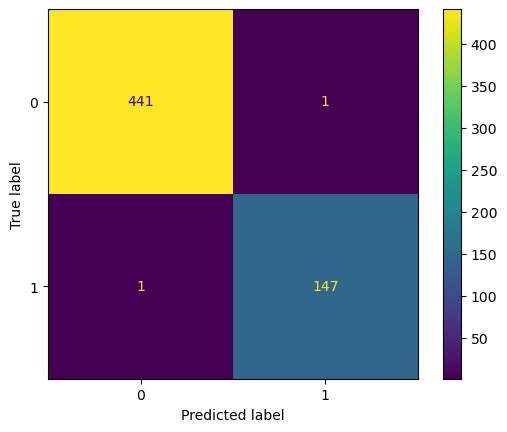


Validation Set
Predictions : torch.Size([147])
Binary Class Evaluation

True Positive : 24
False Positive : 11
False Negative : 13
True Negative : 99

Class non-rumour Evaluation
- Precision : 68.571 %
- Recall : 64.865 %
- F1 : 0.66667

Class rumour Evaluation
- Precision : 88.393 %
- Recall : 90.0 %
- F1 : 0.89189

Combined Evaluation
- Accuracy : 83.673 %
- Precision : 78.482 %
- Recall : 77.432 %
- F1 : 0.77953
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Validation, 83.673, 78.482, 77.432, 0.77953, 68.571, 64.865, 0.66667, 88.393, 90.0, 0.89189, 
Confusion Matrix Scikit-learn: 
[[99 11]
 [13 24]]


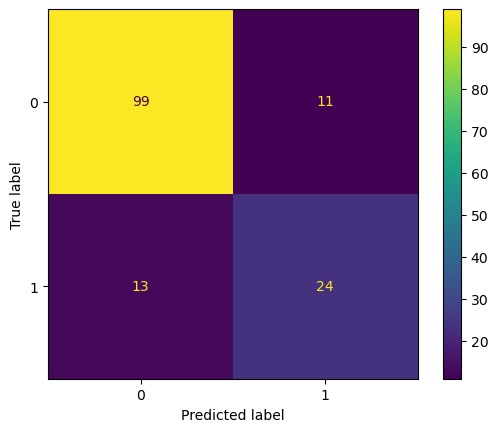


Test Set
Predictions : torch.Size([81])
Binary Class Evaluation

True Positive : 14
False Positive : 0
False Negative : 6
True Negative : 61

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 70.0 %
- F1 : 0.82353

Class rumour Evaluation
- Precision : 91.045 %
- Recall : 100.0 %
- F1 : 0.95312

Combined Evaluation
- Accuracy : 92.593 %
- Precision : 95.522 %
- Recall : 85.0 %
- F1 : 0.89954
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter16-RNR_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Test, 92.593, 95.522, 85.0, 0.89954, 100.0, 70.0, 0.82353, 91.045, 100.0, 0.95312, 
81
81
Confusion Matrix Scikit-learn: 
[[61  0]
 [ 6 14]]


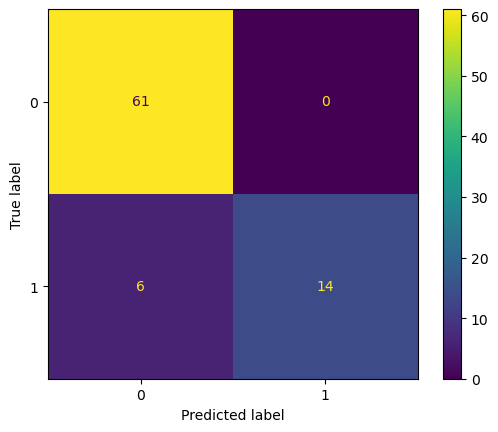

In [12]:
print("Multiclass Classification using 4-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_4LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()